# Excess mortality in Russia by weeks in 2020

Note: the data do not include Crimea as well as deaths with unknown week of death

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
import matplotlib as mpl

col2020 = '#e41a1c'

from matplotlib.patches import Polygon

In [2]:
from sklearn.linear_model import LinearRegression

def predict(X):    
    # Fit regression model on pre-2020 data 
    ind = (X[:,0] < 2020) & (X[:,1]<53)
    m = np.max(X[ind,1])
    onehot = np.zeros((np.sum(ind), m))
    for i,k in enumerate(X[ind,1]):
        onehot[i,k-1] = 1
    predictors = np.concatenate((X[ind,:1], onehot), axis=1)
    reg = LinearRegression(fit_intercept=False).fit(predictors, X[ind,2])
        
    # Compute 2020 baseline
    ind2 = X[:,0] == 2020
    predictors2020 = np.concatenate((np.ones((m,1))*2020, np.eye(m)), axis=1)
    baseline = reg.predict(predictors2020)
            
    # Week 53 usually does not have enough data, so we'll use 
    # the same baseline value as for week 52
    if np.max(X[:,1])==53:
        baseline = np.concatenate((baseline, [baseline[-1]]))
    
    return baseline

## STMF data

In [3]:
df_stmf = pd.read_csv('https://www.mortality.org/Public/STMF/Outputs/stmf.csv', skiprows=2)

df_stmf

,CountryCode,Year,Week,Sex,D0_14,D15_64,D65_74,D75_84,D85p,DTotal,R0_14,R15_64,R65_74,R75_84,R85p,RTotal,Split,SplitSex,Forecast
0,AUS2,2015,1,m,5.037600,210.962400,204.0,398.0,394.0,1212.0,0.000113,0.001395,0.010716,0.041683,0.119154,0.005326,1,0,0
1,AUS2,2015,1,f,6.758007,141.241993,154.0,323.0,676.0,1301.0,0.000160,0.000929,0.007869,0.028785,0.118644,0.005641,1,0,0
2,AUS2,2015,1,b,11.795607,352.204393,358.0,721.0,1070.0,2513.0,0.000136,0.001161,0.009273,0.034714,0.118831,0.005484,1,0,0
3,AUS2,2015,2,m,5.648218,166.351782,216.0,343.0,399.0,1130.0,0.000127,0.001100,0.011347,0.035923,0.120666,0.004966,1,0,0
4,AUS2,2015,2,f,6.983274,149.016726,147.0,290.0,646.0,1239.0,0.000166,0.000980,0.007511,0.025844,0.113378,0.005372,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108298,USA,2021,42,f,207.000000,6142.000000,5728.0,7355.0,10255.0,29687.0,0.000370,0.003009,0.016652,0.039804,0.121859,0.009238,0,0,1
108299,USA,2021,42,b,446.000000,16891.000000,13207.0,15341.0,17172.0,63057.0,0.000390,0.004139,0.020488,0.046479,0.129597,0.009959,0,0,1
108300,USA,2021,43,m,254.000000,10121.000000,7339.0,7820.0,6763.0,32297.0,0.000435,0.004963,0.024410,0.053827,0.139880,0.010357,0,0,1
108301,USA,2021,43,f,202.000000,6050.000000,5514.0,7226.0,10442.0,29434.0,0.000361,0.002964,0.016030,0.039106,0.124081,0.009159,0,0,1


In [4]:
X = df_stmf[(df_stmf['CountryCode']=='RUS') & (df_stmf['Sex']=='b')]
X = X[['Year','Week','DTotal']].values
X = X[X[:,0] >= 2015, :].astype(int)

baseline = predict(X)

<IPython.core.display.Javascript object>


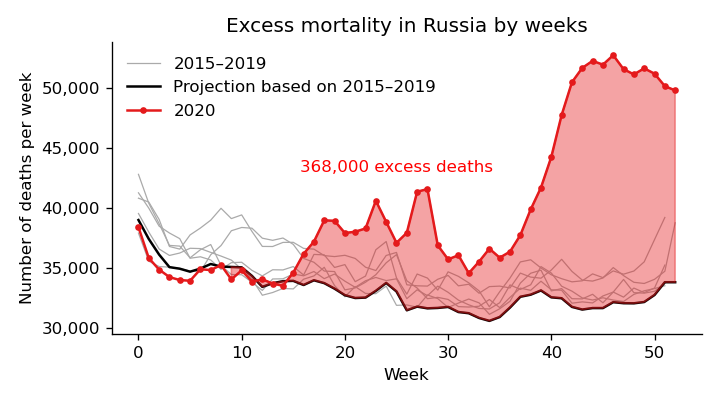

In [5]:
fig = plt.figure(figsize=(8*.75,4.5*.75))

for y in range(2015,2019):
    plt.plot(X[X[:,0]==y,2], linewidth=.75, color='#aaaaaa', label='')
plt.plot(X[X[:,0]==2019,2], linewidth=.75, color='#aaaaaa', label='2015–2019')
plt.plot(baseline, 'k', linewidth=1.5, label='Projection based on 2015–2019')
plt.plot(X[X[:,0]==2020,2], '.-', color=col2020, linewidth=1.5, label='2020')
plt.legend(frameon=False)

a = 9
b = 53
poly = np.zeros(((b-a)*2, 2))
poly[:,0] = np.concatenate((np.arange(a,b), np.arange(b-1,a-1,-1)))
poly[:,1] = np.concatenate((X[X[:,0]==2020,2][a:b], baseline[a:b][::-1]))
poly = Polygon(poly, facecolor=col2020, edgecolor=col2020, alpha=.4, zorder=5)
plt.gca().add_patch(poly)

plt.ylabel('Number of deaths per week')
plt.title('Excess mortality in Russia by weeks')
plt.gca().get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# plt.xticks([0]+list(np.arange(4,53,5)), [1]+list(np.arange(4,53,5)+1))
# plt.ylim([0,55_000])
plt.xlabel('Week')

sns.despine()
plt.tight_layout()

total = np.sum((X[X[:,0]==2020,2]-baseline)[9:])
plt.text(25,43000,f'{np.round(total/1000)*1000:,.0f} excess deaths',
         color='r', ha='center')


plt.savefig('img/russia-weekly-excess.png', dpi=200)

## STMF input data (5-year age bands)

In [6]:
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2

r = urllib2.urlopen('https://www.mortality.org/Public/STMF/Inputs/STMFinput.zip').read()
file = ZipFile(BytesIO(r))
csv = file.open('RUSstmf.csv')
df_stmf_narrow_raw = pd.read_csv(csv)

df_stmf_narrow_raw

,PopCode,Area,Year,Week,Sex,Age,AgeInterval,Deaths,Type,Access
0,RUS,1,2000,1,m,0,5,282.00,O,O
1,RUS,1,2000,1,m,5,5,32.00,O,O
2,RUS,1,2000,1,m,10,5,54.00,O,O
3,RUS,1,2000,1,m,15,5,283.00,O,O
4,RUS,1,2000,1,m,20,5,468.00,O,O
...,...,...,...,...,...,...,...,...,...,...
67275,RUS,1,2020,53,f,80,5,5591.25,O,O
67276,RUS,1,2020,53,f,85,5,3533.25,O,O
67277,RUS,1,2020,53,f,90,5,2721.25,O,O
67278,RUS,1,2020,53,f,95,+,756.00,O,O


In [7]:
df_stmf_narrow = df_stmf_narrow_raw.copy()

for year in [2019, 2020]:
    for week in range(2,54):
        for sex in ['f', 'm']:
            df_stmf_narrow.loc[
                (df_stmf_narrow['Year']==year) &
                (df_stmf_narrow['Week']==week) &
                (df_stmf_narrow['Sex']==sex) &
                (df_stmf_narrow['Age']=='0'),
                'Deaths'
            ] = df_stmf_narrow[
                (df_stmf_narrow['Year']==year) &
                (df_stmf_narrow['Week']==week) &
                (df_stmf_narrow['Sex']==sex) &
                (df_stmf_narrow['Age']=='0')
            ]['Deaths'].values + df_stmf_narrow[
                (df_stmf_narrow['Year']==year) &
                (df_stmf_narrow['Week']==week) &
                (df_stmf_narrow['Sex']==sex) &
                (df_stmf_narrow['Age']=='1')
            ]['Deaths'].values
            
            df_stmf_narrow.loc[
                (df_stmf_narrow['Year']==year) &
                (df_stmf_narrow['Week']==week) &
                (df_stmf_narrow['Sex']==sex) &
                (df_stmf_narrow['Age']=='0'),
                'AgeInterval'
            ] = 5
            
for year in [2019,2020]:
    for week in range(2,54):
        for sex in ['f', 'm']:
            df_stmf_narrow.loc[
                (df_stmf_narrow['Year']==year) &
                (df_stmf_narrow['Week']==week) &
                (df_stmf_narrow['Sex']==sex) &
                (df_stmf_narrow['Age']=='90'),
                'Deaths'
            ] = df_stmf_narrow[
                (df_stmf_narrow['Year']==year) &
                (df_stmf_narrow['Week']==week) &
                (df_stmf_narrow['Sex']==sex) &
                (df_stmf_narrow['Age']=='90')
            ]['Deaths'].values + df_stmf_narrow[
                (df_stmf_narrow['Year']==year) &
                (df_stmf_narrow['Week']==week) &
                (df_stmf_narrow['Sex']==sex) &
                (df_stmf_narrow['Age']=='95')
            ]['Deaths'].values
            
            df_stmf_narrow.loc[
                (df_stmf_narrow['Year']==year) &
                (df_stmf_narrow['Week']==week) &
                (df_stmf_narrow['Sex']==sex) &
                (df_stmf_narrow['Age']=='90'),
                'AgeInterval'
            ] = '+'

In [8]:
table = pd.read_excel('russian-data/raw/population_by_age_1_jan_2020/1-1-1.xlsx')
# print(table.values[11::6,1])

population_by_age_2020 = table.values[11::6,[4,5]]
population_by_age_2020[-2] += population_by_age_2020[-1]
population_by_age_2020 = population_by_age_2020[:-1]

table = pd.read_excel('russian-data/raw/population_by_age_1_jan_2020/2-3-3.xlsx')
ind = [14,22,30,40,46,52,60,67,74,80,87,93,99,105,111,117,118,119]
# print(table.values[ind,1])

crimea = table.values[ind][:,[4,5]]

table = pd.read_excel('russian-data/raw/population_by_age_1_jan_2020/2-3-8.xlsx')
ind = [14,22,30,40,46,52,60,67,74,80,87,93,99,105,111,117,118,119]
# print(table.values[ind,1])

crimea += table.values[ind][:,[4,5]]

crimea[-2] -= crimea[-1]

ratio = np.sum(population_by_age_2020[-2]) / np.sum(population_by_age_2020[-2:])
crimea = np.concatenate((crimea, [[0,0]]))
crimea[-1] = crimea[-2] * (1-ratio)
crimea[-2] = crimea[-2] * ratio

population_by_age_2020 -= crimea

population_by_age_2020

array([[4347580, 4087001],
       [4712231, 4448643],
       [4057272, 3856025],
       [3611687, 3439494],
       [3459082, 3317546],
       [4759685, 4513767],
       [6257870, 6155581],
       [5855421, 5932913],
       [5091429, 5426934],
       [4649682, 5073680],
       [4049975, 4639050],
       [4580412, 5675516],
       [4134713, 5778302],
       [3119761, 5038173],
       [1902528, 3522526],
       [894818, 2153485],
       [896096, 2576920],
       [314971.07359715906, 1032766.5381309987],
       [151948.92640284097, 547324.4618690013]], dtype=object)

<IPython.core.display.Javascript object>


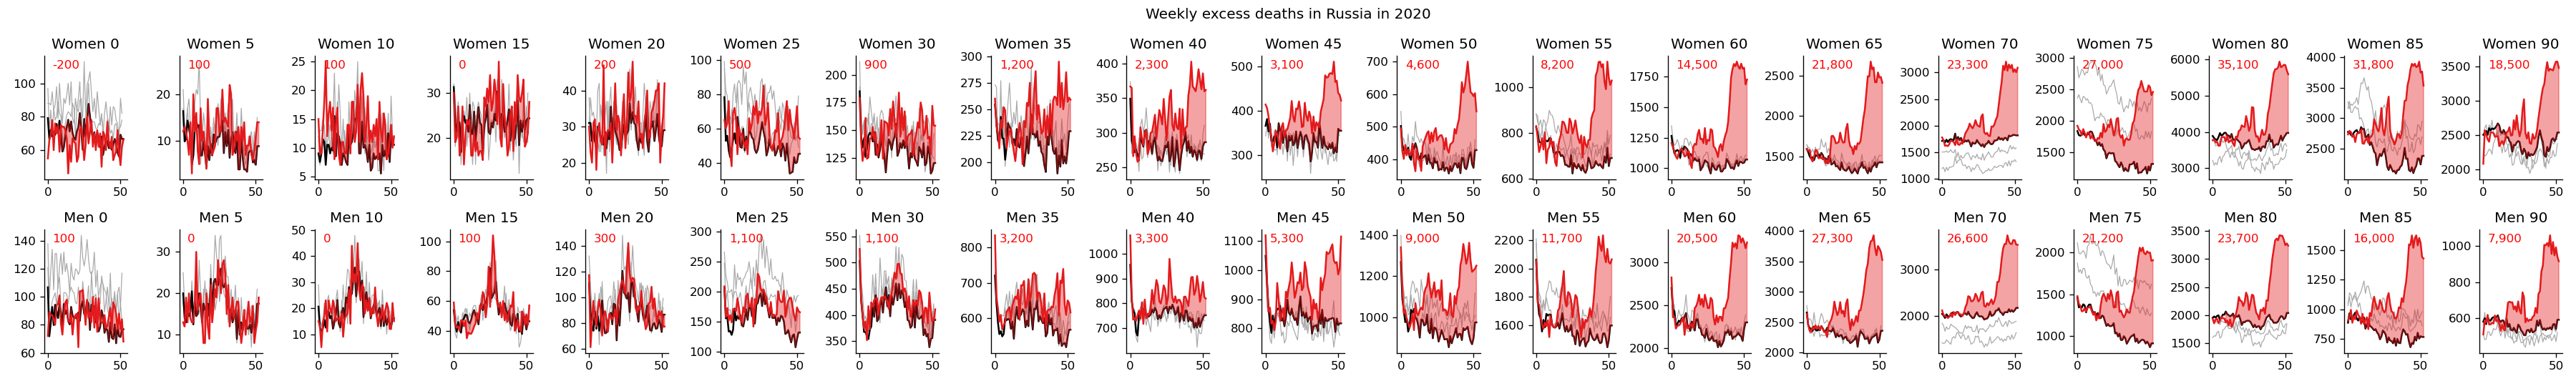

In [9]:
excess_by_age = np.zeros_like(population_by_age_2020)

plt.figure(figsize=(30,4.5))

for age in range(19):
    X = df_stmf_narrow[(df_stmf_narrow['Sex']=='f') & (df_stmf_narrow['Age']==str(age*5))]
    X = X[['Year','Week','Deaths']].values
    X = X[X[:,0] >= 2018, :].astype(int)
    
    baseline = predict(X)
    
    plt.subplot(2,19,age+1)
    
    for y in range(2015,2020):
        plt.plot(X[X[:,0]==y,2], linewidth=.75, color='#aaaaaa')
    plt.plot(baseline, 'k', linewidth=1.5)
    plt.plot(X[X[:,0]==2020,2], color=col2020, linewidth=1.5)

    a = 9
    b = 53
    poly = np.zeros(((b-a)*2, 2))
    poly[:,0] = np.concatenate((np.arange(a,b), np.arange(b-1,a-1,-1)))
    poly[:,1] = np.concatenate((X[X[:,0]==2020,2][a:b], baseline[a:b][::-1]))
    poly = Polygon(poly, facecolor=col2020, edgecolor=col2020, alpha=.4, zorder=5)
    plt.gca().add_patch(poly)
    
    plt.title(f'Women {age*5}')
    
    total = np.sum((X[X[:,0]==2020,2]-baseline)[9:])
    plt.text(.1, .9, f'{np.round(total/100)*100:,.0f}',
         color='r', transform=plt.gca().transAxes)
    excess_by_age[age,1] = total
    
for age in range(19):
    X = df_stmf_narrow[(df_stmf_narrow['Sex']=='m') & (df_stmf_narrow['Age']==str(age*5))]
    X = X[['Year','Week','Deaths']].values
    X = X[X[:,0] >= 2018, :].astype(int)
    
    baseline = predict(X)
    
    plt.subplot(2,19,19+age+1)
    
    for y in range(2015,2020):
        plt.plot(X[X[:,0]==y,2], linewidth=.75, color='#aaaaaa')
    plt.plot(baseline, 'k', linewidth=1.5)
    plt.plot(X[X[:,0]==2020,2], color=col2020, linewidth=1.5)

    a = 9
    b = 53
    poly = np.zeros(((b-a)*2, 2))
    poly[:,0] = np.concatenate((np.arange(a,b), np.arange(b-1,a-1,-1)))
    poly[:,1] = np.concatenate((X[X[:,0]==2020,2][a:b], baseline[a:b][::-1]))
    poly = Polygon(poly, facecolor=col2020, edgecolor=col2020, alpha=.4, zorder=5)
    plt.gca().add_patch(poly)

    plt.title(f'Men {age*5}')
    
    total = np.sum((X[X[:,0]==2020,2]-baseline)[9:])
    plt.text(.1, .9, f'{np.round(total/100)*100:,.0f}',
         color='r', transform=plt.gca().transAxes)
    excess_by_age[age,0] = total

sns.despine()
plt.suptitle(f'Weekly excess deaths in Russia in 2020')

plt.tight_layout()

plt.savefig(f'img/russia-weekly-excess-agebands.png', dpi=200)

<IPython.core.display.Javascript object>


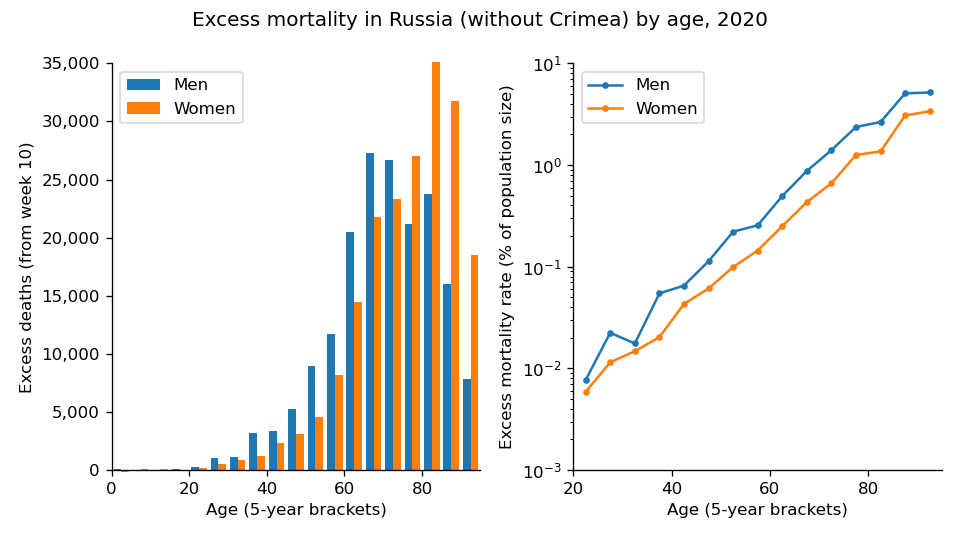

In [10]:
plt.figure(figsize=(8,4.5))

plt.subplot(121)

plt.bar(np.arange(1.5,95,5), excess_by_age[:,0], width=2, label='Men', clip_on=False)
plt.bar(np.arange(3.5,95,5), excess_by_age[:,1], width=2, label='Women', clip_on=False)
plt.xlabel('Age (5-year brackets)')
plt.ylabel('Excess deaths (from week 10)')
plt.ylim([0,35000])
plt.xlim([0,95])
plt.legend()

plt.gca().get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.subplot(122)

rate = excess_by_age[4:] / population_by_age_2020[4:] * 100

plt.plot(np.arange(22.5,95,5), rate[:,0], '.-', label='Men')
plt.plot(np.arange(22.5,95,5), rate[:,1], '.-', label='Women')
plt.ylabel('Excess mortality rate (% of population size)')
plt.xlabel('Age (5-year brackets)')
plt.yscale('log')
plt.xlim([20,95])
plt.ylim([0.001, 10])
plt.legend()

plt.suptitle('Excess mortality in Russia (without Crimea) by age, 2020')
sns.despine()
plt.tight_layout()

plt.savefig('img/russia-weekly-excess-agebands-summary.png', dpi=200)